In [1]:
!nvidia-smi

Fri Nov 26 07:04:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
# pytorch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 cudatoolkit=11.1 
!pip install torchaudio==0.8.0 

     |████████████████████████████████| 1.9 MB 5.5 MB/s 
     |████████████████████████████████| 735.5 MB 15 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.


In [4]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import torch.optim as optim
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/IE\ 643/Challenge/challenge_dataset
!ls

/content/drive/MyDrive/IE 643/Challenge/challenge_dataset
1  2  3  4  5  6  7


In [ ]:
# testing out one audio 
Audio('1/'+ os.listdir('1')[3])

In [7]:
data = [] # list of dictionaries

for folder in os.listdir():
  for file in os.listdir(folder):
    d = dict()
    label = np.zeros(7)
    d['path'] = os.path.join(folder, file)
    # label[int(folder)-1]=1
    # d['label'] = label 
    d['label'] = int(folder)-1
    data.append(d)

In [8]:
data[0]['label']

2

In [9]:
## avg duration of the audio files
def avg_duration():
    dur = 0
    for item in data:
      aud,sr = torchaudio.load(item['path'])
      dur += aud[0].shape[0]/sr
    avg_dur = dur/len(data)
    print('Average duration of audio = ',avg_dur)

In [10]:
# avg_length()
## Average duration of audio =  5.293358867356467

In [11]:
def ConvertToTrio(aud):
  if aud.shape[0]==3:
    return aud
  elif aud.shape[0]==1:
    return torch.cat([aud,aud,aud])
  else:
    return aud[:3,:,:]

In [12]:
def ChangeSR(aud, sr, new_sr):
  '''changes sample rate for stereo audio signals'''

  if sr==new_sr:
    return aud
  
  else:
    resample1 = torchaudio.transforms.Resample(sr, newsr)(aud[:1,:])
    resample2 = torchaudio.transforms.Resample(sr, newsr)(aud[1:,:])
    return torch.cat([resample1,resample2])

In [13]:
def Resize(aud,sr,new_duration):
  orig_length = aud[0].shape[0]
  new_length = int(sr*new_duration)
  if orig_length >= new_length:
    return aud[:,:new_length]
  else:
    z = torch.zeros((aud.shape[0],new_length))
    z[:,:orig_length]=aud
    return z

In [14]:
## Dataset Class

class AudioDataset(Dataset):
  
  def __init__(self, data):
    self.data = data
    self.sr = 44100       ## the most common sampling rate for music
    self.duration = 5.0   ## duration of all audio files (in seconds)
    self.length = 10000
    
  def __len__(self):
    return len(data)

  def __getitem__(self, idx):
    # print(idx)
    path = data[idx%len(data)]['path']
    label = data[idx%len(data)]['label']
    # path = data[idx]['path']
    # label = data[idx]['label']
    aud, sr = torchaudio.load(path)  # aud=audio tensor, sr=sampling rate
    
    # preprocessing
    aud = ConvertToTrio(aud)       # keeping 3 channels 
    aud = ChangeSR(aud,sr,self.sr)   # choosing the conventional sr 
    aud = Resize(aud, self.sr, self.duration)
    # print(aud.size())
    mel_spec = torchaudio.transforms.MelSpectrogram(self.sr, n_mels=64,n_fft=2959)(aud)
    # print(aud.size())
    mel_spec_amp = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel_spec)
    # print(aud.size())
    
    
    # return mel_spec_amp, nn.functional.one_hot(torch.tensor(label))
    return mel_spec_amp, torch.tensor(label)

In [15]:
dataset = AudioDataset(data)

In [16]:
from torch.utils.data import random_split

batch_size = 8

num_items = len(dataset)

### for training with cross-validation ###
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

### for the final training ###
# train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


### Model

In [45]:
import torchvision.models as models
import torchvision.transforms as transforms

M = torch.tensor(np.ones((3,224,224)).astype('float32'))
# M[:,80:144,37:187] = 0    ## for 150x64
# M[:,104:120,104:120] = 0    ## for 16x16
# M[:,96:128,96:128] = 0    ## for 32x32
# M[:,80:144,80:144] = 0    ## for 64x64
M[:,48:178,48:178] = 0    ## for 64x64

class CNN_model(nn.Module):
    def __init__(self):
      super(CNN_model, self).__init__()
      # self.model = nn.Sequential()
      self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
      for layer in self.mobilenet_v2.children():
        for param in layer.parameters():
            param.requires_grad = False
      
      self.W = nn.Parameter(torch.randn(3,224,224))

    def forward(self, input):
      # return self.model(input)
      # input = transforms.Resize((16,16))(input)
      # input = transforms.Resize((32,32))(input)
      # input = transforms.Resize((64,64))(input)
      input = transforms.Resize((128,128))(input)

      # input = nn.functional.pad(input,(37,37,80,80),"constant",0)   ## for 150x64
      # input = nn.functional.pad(input,(104,104,104,104),"constant",0)     ## for 16x16   
      # input = nn.functional.pad(input,(96,96,96,96),"constant",0)     ## for 32x32   
      # input = nn.functional.pad(input,(80,80,80,80),"constant",0)     ## for 64x64     
      input = nn.functional.pad(input,(48,48,48,48),"constant",0)     ## for 128x128   
      prog = nn.Tanh()(self.W*M)
      out = input+prog
      return self.mobilenet_v2(out)

In [46]:
trial=CNN_model()
print(trial.forward(torch.rand((8,3,64,150))).shape)
del trial

torch.Size([8, 1000])


### Training

In [47]:
# l2_lambda = 0.01
# l2_reg = torch.tensor(0.)
# for param in model.parameters():
#     l2_reg += torch.norm(param)
# loss += l2_lambda * l2_reg

In [48]:
model = CNN_model()
# lr = 0.0001
# lr = 0.001
optimizer = optim.Adam(model.parameters())

In [49]:
# co = 0
# for p in model.parameters():
#   co+=1
# print(co)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

150528

In [50]:
# mel_spec.shape = [2, 64, 431]

In [51]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [52]:
def train(model, train_dataloader, num_epochs, path, validate=True):
  
  criterion = nn.CrossEntropyLoss()
  l2_lambda = 0.01

  # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
  #                                         steps_per_epoch=int(len(train_dataloader)),
  #                                         epochs=num_epochs,
  #                                         anneal_strategy='linear', 
  #                                         verbose=True)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=2, min_lr=0.000001)
  
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    for i, data in enumerate(train_dataloader):
        # inputs, labels = data[0].to(device), data[1].to(device)
        inputs = data[0]
        # print(data[0].size())
        labels = data[1]

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels) + l2_lambda*torch.norm(model.W)
        loss.backward()
        optimizer.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
    
    # Print stats at the end of the epoch
    num_batches = len(train_dataloader)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    train_loss_list.append(avg_loss)
    train_acc_list.append(acc)
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    ## validation loss
    if (epoch+1)%10 ==0:
      
      ## save the model
      PATH = path+f"_{epoch+1}.pt"
      torch.save({
                  'epoch': epoch+1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  }, PATH)
      
      if validate:
          val_loss = 0
          for i, data in enumerate(val_dataloader):
            # inputs, labels = data[0].to(device), data[1].to(device)
            inputs = data[0]
            # print(data[0].size())
            labels = data[1]

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Keep stats for Loss and Accuracy
            val_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

          # Print stats at the end of the epoch
          num_batches = len(val_dataloader)
          avg_loss = val_loss / num_batches
          scheduler.step(avg_loss)
          acc = correct_prediction/total_prediction
          val_loss_list.append(avg_loss)
          val_acc_list.append(acc)    
          print(f'Epoch: {epoch+1}, Validation Loss: {avg_loss:.2f}, Validation Accuracy: {acc:.2f}')
        
  print('Finished Training')
  plt.figure(figsize=(7,7))
  plt.plot(np.arange(0,num_epochs,1),train_loss_list, label='training loss')
  if validate:
    plt.plot(np.arange(10,num_epochs+1,10),val_loss_list, label='validation loss')
  plt.legend()
  plt.show()
  plt.figure(figsize=(7,7))
  plt.plot(np.arange(0,num_epochs,1),train_acc_list, label='training accuracy')
  if validate:
    plt.plot(np.arange(10,num_epochs+1,10),val_acc_list, label='validation accuracy')
  plt.legend()
  plt.show()

Epoch: 1, Loss: 13.60, Accuracy: 0.00
Epoch: 2, Loss: 13.34, Accuracy: 0.00
Epoch: 3, Loss: 13.13, Accuracy: 0.00
Epoch: 4, Loss: 13.04, Accuracy: 0.00
Epoch: 5, Loss: 12.78, Accuracy: 0.00
Epoch: 6, Loss: 12.74, Accuracy: 0.00
Epoch: 7, Loss: 12.65, Accuracy: 0.00
Epoch: 8, Loss: 12.54, Accuracy: 0.00
Epoch: 9, Loss: 12.37, Accuracy: 0.00
Epoch: 10, Loss: 12.36, Accuracy: 0.00
Epoch: 10, Validation Loss: 8.22, Validation Accuracy: 0.00
Epoch: 11, Loss: 12.12, Accuracy: 0.00
Epoch: 12, Loss: 12.16, Accuracy: 0.00
Epoch: 13, Loss: 12.02, Accuracy: 0.00
Epoch: 14, Loss: 12.02, Accuracy: 0.00
Epoch: 15, Loss: 11.86, Accuracy: 0.00
Epoch: 16, Loss: 11.93, Accuracy: 0.00
Epoch: 17, Loss: 11.66, Accuracy: 0.01
Epoch: 18, Loss: 11.67, Accuracy: 0.01
Epoch: 19, Loss: 11.52, Accuracy: 0.00
Epoch: 20, Loss: 11.60, Accuracy: 0.00
Epoch: 20, Validation Loss: 8.10, Validation Accuracy: 0.00
Finished Training


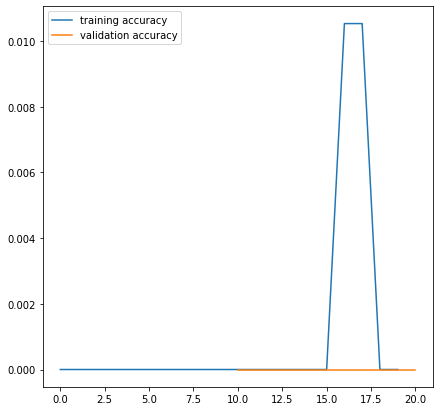

In [53]:
## EXP2
# 128x128
num_epochs=20
path = '/content/drive/MyDrive/CS663 Project/audio_model_exp2_128'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 12.92, Accuracy: 0.00
Epoch: 2, Loss: 12.50, Accuracy: 0.00
Epoch: 3, Loss: 12.33, Accuracy: 0.00
Epoch: 4, Loss: 11.98, Accuracy: 0.01
Epoch: 5, Loss: 11.69, Accuracy: 0.00
Epoch: 6, Loss: 11.53, Accuracy: 0.02
Epoch: 7, Loss: 11.43, Accuracy: 0.01
Epoch: 8, Loss: 11.25, Accuracy: 0.01
Epoch: 9, Loss: 11.04, Accuracy: 0.03
Epoch: 10, Loss: 10.82, Accuracy: 0.02
Epoch: 10, Validation Loss: 7.19, Validation Accuracy: 0.03
Epoch: 11, Loss: 10.62, Accuracy: 0.05
Epoch: 12, Loss: 10.52, Accuracy: 0.02
Epoch: 13, Loss: 10.26, Accuracy: 0.03
Epoch: 14, Loss: 10.35, Accuracy: 0.03
Epoch: 15, Loss: 10.44, Accuracy: 0.04
Epoch: 16, Loss: 9.95, Accuracy: 0.12
Epoch: 17, Loss: 10.25, Accuracy: 0.04
Epoch: 18, Loss: 10.26, Accuracy: 0.05
Epoch: 19, Loss: 10.10, Accuracy: 0.07
Epoch: 20, Loss: 9.98, Accuracy: 0.09
Epoch: 20, Validation Loss: 6.71, Validation Accuracy: 0.09
Finished Training


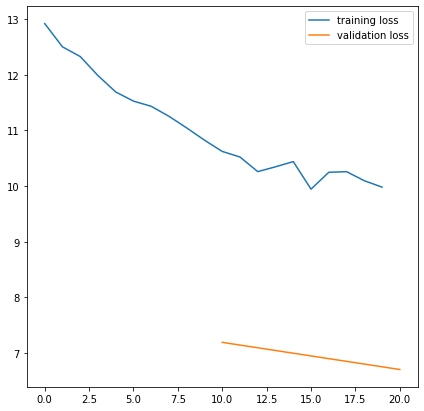

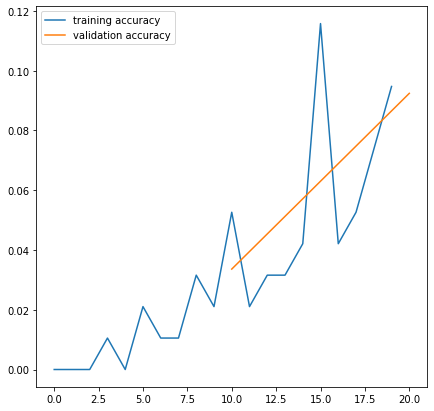

In [44]:
## EXP2
# 64x64
num_epochs=20
path = '/content/drive/MyDrive/CS663 Project/audio_model_exp2_64'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 12.60, Accuracy: 0.00
Epoch: 2, Loss: 12.20, Accuracy: 0.00
Epoch: 3, Loss: 12.02, Accuracy: 0.00
Epoch: 4, Loss: 11.77, Accuracy: 0.00
Epoch: 5, Loss: 11.52, Accuracy: 0.00
Epoch: 6, Loss: 11.20, Accuracy: 0.00
Epoch: 7, Loss: 11.16, Accuracy: 0.00
Epoch: 8, Loss: 10.83, Accuracy: 0.02
Epoch: 9, Loss: 10.85, Accuracy: 0.01
Epoch: 10, Loss: 10.59, Accuracy: 0.01
Epoch: 10, Validation Loss: 7.36, Validation Accuracy: 0.01
Epoch: 11, Loss: 10.63, Accuracy: 0.02
Epoch: 12, Loss: 10.57, Accuracy: 0.00
Epoch: 13, Loss: 10.62, Accuracy: 0.04
Epoch: 14, Loss: 10.41, Accuracy: 0.02
Epoch: 15, Loss: 10.15, Accuracy: 0.05
Epoch: 16, Loss: 10.17, Accuracy: 0.06
Epoch: 17, Loss: 9.83, Accuracy: 0.07
Epoch: 18, Loss: 10.07, Accuracy: 0.09
Epoch: 19, Loss: 9.98, Accuracy: 0.11
Epoch: 20, Loss: 9.50, Accuracy: 0.17
Epoch: 20, Validation Loss: 6.49, Validation Accuracy: 0.15
Finished Training


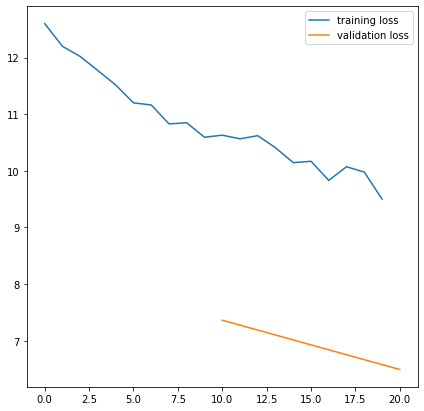

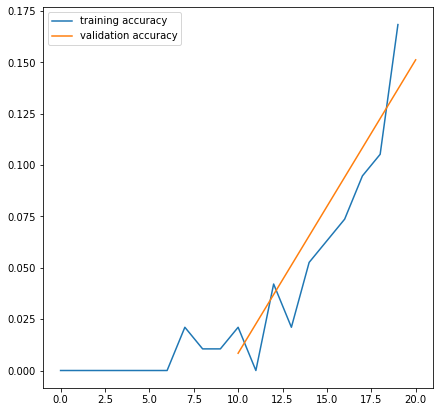

In [35]:
## EXP2
# 32x32
num_epochs=20
path = '/content/drive/MyDrive/CS663 Project/audio_model_exp2_32'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 12.66, Accuracy: 0.00
Epoch: 2, Loss: 12.18, Accuracy: 0.00
Epoch: 3, Loss: 11.80, Accuracy: 0.00
Epoch: 4, Loss: 11.48, Accuracy: 0.00
Epoch: 5, Loss: 11.29, Accuracy: 0.00
Epoch: 6, Loss: 10.93, Accuracy: 0.01
Epoch: 7, Loss: 11.29, Accuracy: 0.00
Epoch: 8, Loss: 10.77, Accuracy: 0.00
Epoch: 9, Loss: 10.41, Accuracy: 0.01
Epoch: 10, Loss: 10.54, Accuracy: 0.03
Epoch: 10, Validation Loss: 7.33, Validation Accuracy: 0.03
Epoch: 11, Loss: 10.31, Accuracy: 0.04
Epoch: 12, Loss: 10.31, Accuracy: 0.05
Epoch: 13, Loss: 10.41, Accuracy: 0.07
Epoch: 14, Loss: 9.89, Accuracy: 0.07
Epoch: 15, Loss: 10.02, Accuracy: 0.09
Epoch: 16, Loss: 9.73, Accuracy: 0.12
Epoch: 17, Loss: 9.82, Accuracy: 0.16
Epoch: 18, Loss: 9.67, Accuracy: 0.15
Epoch: 19, Loss: 9.52, Accuracy: 0.17
Epoch: 20, Loss: 9.35, Accuracy: 0.21
Epoch: 20, Validation Loss: 6.70, Validation Accuracy: 0.18
Finished Training


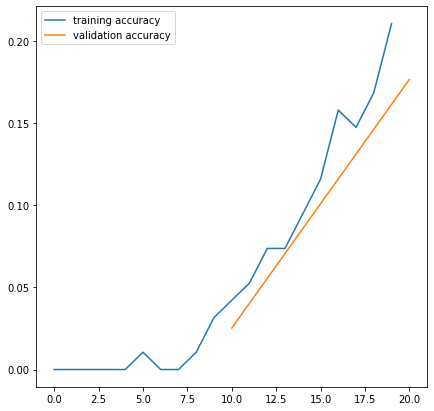

In [26]:
## EXP2
# 16x16
num_epochs=20
path = '/content/drive/MyDrive/CS663 Project/audio_model_exp2_16'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 12.70, Accuracy: 0.00
Epoch: 2, Loss: 12.18, Accuracy: 0.00
Epoch: 3, Loss: 11.91, Accuracy: 0.00
Epoch: 4, Loss: 11.73, Accuracy: 0.00
Epoch: 5, Loss: 11.38, Accuracy: 0.00
Epoch: 6, Loss: 11.33, Accuracy: 0.00
Epoch: 7, Loss: 11.06, Accuracy: 0.00
Epoch: 8, Loss: 10.95, Accuracy: 0.02
Epoch: 9, Loss: 10.61, Accuracy: 0.02
Epoch: 10, Loss: 10.59, Accuracy: 0.05
Epoch: 10, Validation Loss: 7.84, Validation Accuracy: 0.04
Epoch: 11, Loss: 10.62, Accuracy: 0.01
Epoch: 12, Loss: 10.26, Accuracy: 0.03
Epoch: 13, Loss: 10.01, Accuracy: 0.08
Epoch: 14, Loss: 10.22, Accuracy: 0.12
Epoch: 15, Loss: 10.02, Accuracy: 0.11
Epoch: 16, Loss: 9.97, Accuracy: 0.12
Epoch: 17, Loss: 9.66, Accuracy: 0.14
Epoch: 18, Loss: 9.56, Accuracy: 0.11
Epoch: 19, Loss: 9.36, Accuracy: 0.15
Epoch: 20, Loss: 9.36, Accuracy: 0.17
Epoch: 20, Validation Loss: 7.20, Validation Accuracy: 0.14
Epoch: 21, Loss: 9.32, Accuracy: 0.19
Epoch: 22, Loss: 9.52, Accuracy: 0.17
Epoch: 23, Loss: 9.11, Accuracy: 0.26


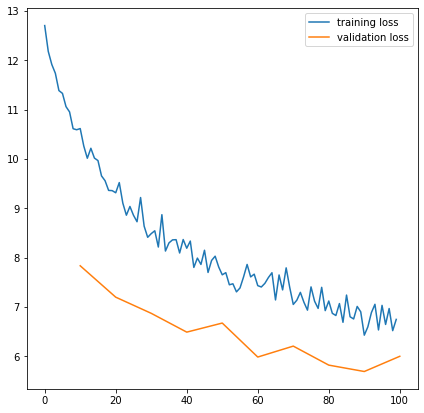

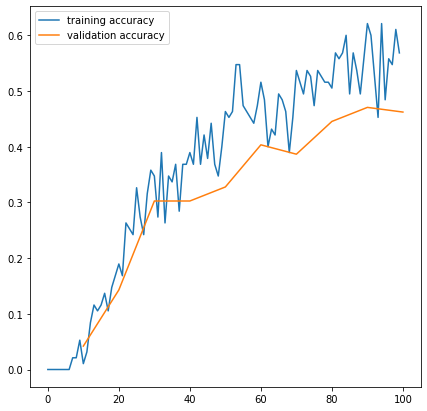

In [ ]:
## resized the spectrogram image to 32x32 
## and changed the padding and mask accordingly
num_epochs = 100
path = '/content/drive/MyDrive/CS663 Project/audio_model2'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 6.90, Accuracy: 0.59
Epoch: 2, Loss: 6.52, Accuracy: 0.63
Epoch: 3, Loss: 6.67, Accuracy: 0.60
Epoch: 4, Loss: 6.58, Accuracy: 0.66
Epoch: 5, Loss: 6.72, Accuracy: 0.60
Epoch: 6, Loss: 6.74, Accuracy: 0.52
Epoch: 7, Loss: 6.62, Accuracy: 0.58
Epoch: 8, Loss: 6.75, Accuracy: 0.60
Epoch: 9, Loss: 6.44, Accuracy: 0.56
Epoch: 10, Loss: 6.49, Accuracy: 0.59
Epoch: 10, Validation Loss: 5.78, Validation Accuracy: 0.51
Epoch: 11, Loss: 6.58, Accuracy: 0.59
Epoch: 12, Loss: 6.57, Accuracy: 0.55
Epoch: 13, Loss: 6.45, Accuracy: 0.63
Epoch: 14, Loss: 6.23, Accuracy: 0.68
Epoch: 15, Loss: 6.26, Accuracy: 0.67
Epoch: 16, Loss: 6.17, Accuracy: 0.73
Epoch: 17, Loss: 6.64, Accuracy: 0.57
Epoch: 18, Loss: 6.88, Accuracy: 0.57
Epoch: 19, Loss: 6.23, Accuracy: 0.64
Epoch: 20, Loss: 6.71, Accuracy: 0.57
Epoch: 20, Validation Loss: 5.91, Validation Accuracy: 0.47
Epoch: 21, Loss: 6.26, Accuracy: 0.69
Epoch: 22, Loss: 6.27, Accuracy: 0.65
Epoch: 23, Loss: 6.23, Accuracy: 0.65
Epoch: 24, Loss

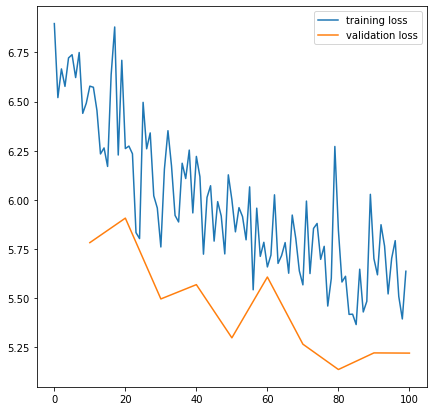

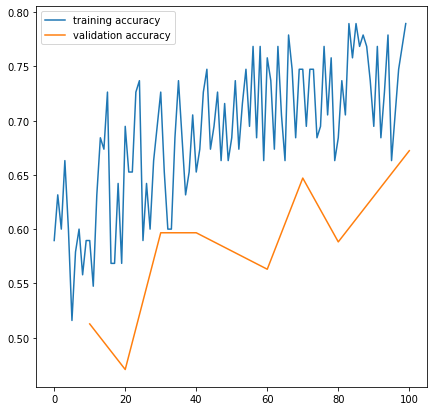

In [ ]:
num_epochs = 100
path = '/content/drive/MyDrive/CS663 Project/audio_model2_100+'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 5.87, Accuracy: 0.68
Epoch: 2, Loss: 5.64, Accuracy: 0.71
Epoch: 3, Loss: 5.54, Accuracy: 0.83
Epoch: 4, Loss: 5.70, Accuracy: 0.76
Epoch: 5, Loss: 5.82, Accuracy: 0.72
Epoch: 6, Loss: 5.57, Accuracy: 0.78
Epoch: 7, Loss: 5.37, Accuracy: 0.75
Epoch: 8, Loss: 5.43, Accuracy: 0.78
Epoch: 9, Loss: 5.72, Accuracy: 0.75
Epoch: 10, Loss: 5.80, Accuracy: 0.68
Epoch: 10, Validation Loss: 5.22, Validation Accuracy: 0.60
Epoch: 11, Loss: 5.44, Accuracy: 0.72
Epoch: 12, Loss: 5.58, Accuracy: 0.76
Epoch: 13, Loss: 5.39, Accuracy: 0.77
Epoch: 14, Loss: 5.35, Accuracy: 0.81
Epoch: 15, Loss: 5.31, Accuracy: 0.80
Epoch: 16, Loss: 5.28, Accuracy: 0.78
Epoch: 17, Loss: 5.22, Accuracy: 0.78
Epoch: 18, Loss: 5.34, Accuracy: 0.78
Epoch: 19, Loss: 5.60, Accuracy: 0.76
Epoch: 20, Loss: 4.87, Accuracy: 0.89
Epoch: 20, Validation Loss: 4.80, Validation Accuracy: 0.78
Epoch: 21, Loss: 5.49, Accuracy: 0.77
Epoch: 22, Loss: 5.74, Accuracy: 0.72
Epoch: 23, Loss: 5.47, Accuracy: 0.78
Epoch: 24, Loss

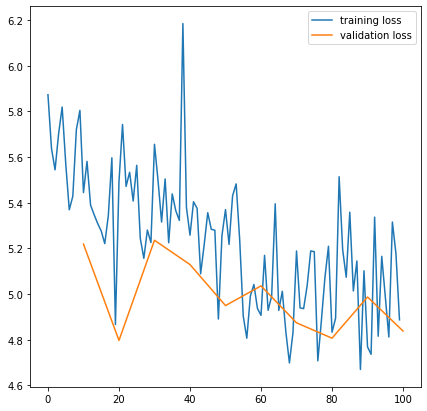

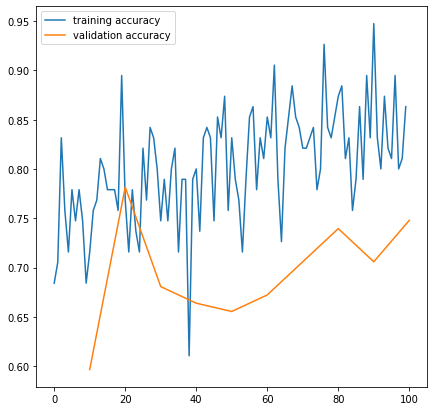

In [ ]:
num_epochs = 100
path = '/content/drive/MyDrive/CS663 Project/audio_model2_200+'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 5.31, Accuracy: 0.77
Epoch: 2, Loss: 5.05, Accuracy: 0.83
Epoch: 3, Loss: 5.01, Accuracy: 0.85
Epoch: 4, Loss: 5.36, Accuracy: 0.76
Epoch: 5, Loss: 5.15, Accuracy: 0.83
Epoch: 6, Loss: 5.15, Accuracy: 0.82
Epoch: 7, Loss: 5.10, Accuracy: 0.80
Epoch: 8, Loss: 4.70, Accuracy: 0.89
Epoch: 9, Loss: 4.89, Accuracy: 0.91
Epoch: 10, Loss: 5.09, Accuracy: 0.82
Epoch: 10, Validation Loss: 4.83, Validation Accuracy: 0.71
Epoch: 11, Loss: 4.99, Accuracy: 0.80
Epoch: 12, Loss: 5.09, Accuracy: 0.81
Epoch: 13, Loss: 5.20, Accuracy: 0.77
Epoch: 14, Loss: 5.27, Accuracy: 0.79
Epoch: 15, Loss: 4.77, Accuracy: 0.93
Epoch: 16, Loss: 4.88, Accuracy: 0.85
Epoch: 17, Loss: 4.70, Accuracy: 0.89
Epoch: 18, Loss: 5.09, Accuracy: 0.83
Epoch: 19, Loss: 4.79, Accuracy: 0.86
Epoch: 20, Loss: 5.20, Accuracy: 0.81
Epoch: 20, Validation Loss: 5.03, Validation Accuracy: 0.71
Epoch: 21, Loss: 4.92, Accuracy: 0.86
Epoch: 22, Loss: 5.06, Accuracy: 0.85
Epoch: 23, Loss: 5.11, Accuracy: 0.82
Epoch: 24, Loss

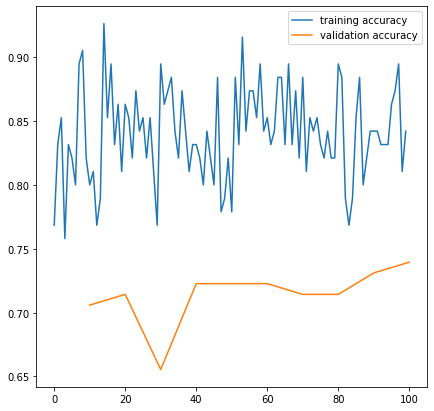

In [ ]:
num_epochs = 100
path = '/content/drive/MyDrive/CS663 Project/audio_model2_300+'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 9.30, Accuracy: 0.15
Epoch: 2, Loss: 9.16, Accuracy: 0.17
Epoch: 3, Loss: 9.15, Accuracy: 0.19
Epoch: 4, Loss: 8.85, Accuracy: 0.22
Epoch: 5, Loss: 9.04, Accuracy: 0.15
Epoch: 6, Loss: 8.85, Accuracy: 0.18
Epoch: 7, Loss: 8.77, Accuracy: 0.21
Epoch: 8, Loss: 8.73, Accuracy: 0.21
Epoch: 9, Loss: 8.90, Accuracy: 0.19
Epoch: 10, Loss: 8.99, Accuracy: 0.19
Epoch: 10, Validation Loss: 7.34, Validation Accuracy: 0.16
Epoch: 11, Loss: 8.69, Accuracy: 0.13
Epoch: 12, Loss: 8.78, Accuracy: 0.23
Epoch: 13, Loss: 8.66, Accuracy: 0.19
Epoch: 14, Loss: 8.71, Accuracy: 0.21
Epoch: 15, Loss: 8.66, Accuracy: 0.20
Epoch: 16, Loss: 8.30, Accuracy: 0.21
Epoch: 17, Loss: 8.67, Accuracy: 0.21
Epoch: 18, Loss: 8.54, Accuracy: 0.22
Epoch: 19, Loss: 8.45, Accuracy: 0.19
Epoch: 20, Loss: 8.72, Accuracy: 0.18
Epoch: 20, Validation Loss: 7.21, Validation Accuracy: 0.16
Epoch: 21, Loss: 8.96, Accuracy: 0.13
Epoch: 22, Loss: 8.35, Accuracy: 0.26
Epoch: 23, Loss: 8.57, Accuracy: 0.24
Epoch: 24, Loss

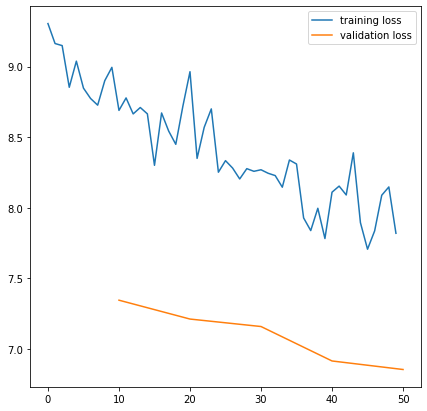

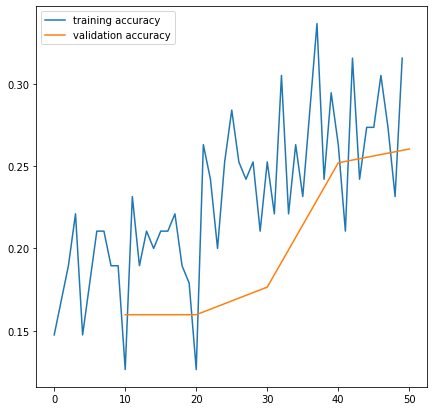

In [ ]:
## freezing the mobilenet weights
num_epochs = 50
path = '/content/drive/MyDrive/CS663 Project/audio_model1_50+_'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 8.06, Accuracy: 0.29
Epoch: 2, Loss: 8.29, Accuracy: 0.22
Epoch: 3, Loss: 8.42, Accuracy: 0.23
Epoch: 4, Loss: 8.13, Accuracy: 0.29
Epoch: 5, Loss: 8.22, Accuracy: 0.28
Epoch: 6, Loss: 8.02, Accuracy: 0.27
Epoch: 7, Loss: 8.08, Accuracy: 0.31
Epoch: 8, Loss: 7.88, Accuracy: 0.33
Epoch: 9, Loss: 8.32, Accuracy: 0.26
Epoch: 10, Loss: 7.90, Accuracy: 0.31
Epoch: 10, Validation Loss: 5.48, Validation Accuracy: 0.29
Epoch: 11, Loss: 8.09, Accuracy: 0.27
Epoch: 12, Loss: 7.61, Accuracy: 0.38
Epoch: 13, Loss: 7.90, Accuracy: 0.27
Epoch: 14, Loss: 7.85, Accuracy: 0.31
Epoch: 15, Loss: 7.64, Accuracy: 0.35
Epoch: 16, Loss: 8.07, Accuracy: 0.29
Epoch: 17, Loss: 7.70, Accuracy: 0.31
Epoch: 18, Loss: 7.70, Accuracy: 0.33
Epoch: 19, Loss: 7.57, Accuracy: 0.31
Epoch: 20, Loss: 7.53, Accuracy: 0.34
Epoch: 20, Validation Loss: 5.80, Validation Accuracy: 0.30
Epoch: 21, Loss: 7.82, Accuracy: 0.25
Epoch: 22, Loss: 7.71, Accuracy: 0.31
Epoch: 23, Loss: 7.67, Accuracy: 0.34
Epoch: 24, Loss

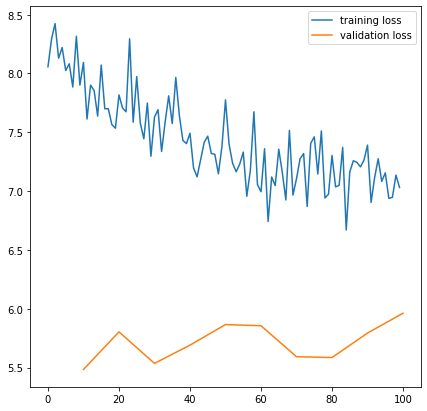

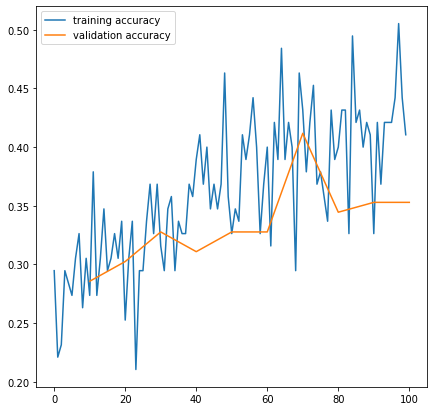

In [ ]:
path = '/content/drive/MyDrive/CS663 Project/audio_model1_50+__50.pt'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

num_epochs = 100
path = '/content/drive/MyDrive/CS663 Project/audio_model1_100+'
train(model, train_dataloader, num_epochs, path)

In [ ]:
## till now model has trained for 200 epochs
## training for 200 more

num_epochs = 200
path = '/content/drive/MyDrive/CS663 Project/audio_model1_200+'
train(model, train_dataloader, num_epochs, path)

Epoch: 1, Loss: 7.12, Accuracy: 0.43
Epoch: 2, Loss: 7.27, Accuracy: 0.37
Epoch: 3, Loss: 6.90, Accuracy: 0.41
Epoch: 4, Loss: 7.05, Accuracy: 0.42
Epoch: 5, Loss: 7.11, Accuracy: 0.43
Epoch: 6, Loss: 7.27, Accuracy: 0.41
Epoch: 7, Loss: 7.16, Accuracy: 0.36
Epoch: 8, Loss: 7.26, Accuracy: 0.42
Epoch: 9, Loss: 7.25, Accuracy: 0.38
Epoch: 10, Loss: 7.10, Accuracy: 0.39
Epoch: 10, Validation Loss: 5.65, Validation Accuracy: 0.34
Epoch: 11, Loss: 7.22, Accuracy: 0.46
Epoch: 12, Loss: 6.84, Accuracy: 0.45
Epoch: 13, Loss: 7.02, Accuracy: 0.42
Epoch: 14, Loss: 7.32, Accuracy: 0.35
Epoch: 15, Loss: 7.22, Accuracy: 0.39
Epoch: 16, Loss: 7.12, Accuracy: 0.40
Epoch: 17, Loss: 7.50, Accuracy: 0.36
Epoch: 18, Loss: 6.88, Accuracy: 0.43
Epoch: 19, Loss: 7.08, Accuracy: 0.37
Epoch: 20, Loss: 7.16, Accuracy: 0.36
Epoch: 20, Validation Loss: 5.58, Validation Accuracy: 0.32
Epoch: 21, Loss: 6.83, Accuracy: 0.48
Epoch: 22, Loss: 7.16, Accuracy: 0.41
Epoch: 23, Loss: 7.44, Accuracy: 0.37
Epoch: 24, Loss

Epoch: 1, Loss: 7.69, Accuracy: 0.34
Epoch: 2, Loss: 5.16, Accuracy: 0.53
Epoch: 3, Loss: 4.69, Accuracy: 0.67
Epoch: 4, Loss: 4.34, Accuracy: 0.83
Epoch: 5, Loss: 4.47, Accuracy: 0.77
Epoch: 6, Loss: 4.79, Accuracy: 0.71
Epoch: 7, Loss: 4.51, Accuracy: 0.77
Epoch: 8, Loss: 4.45, Accuracy: 0.78
Epoch: 9, Loss: 4.41, Accuracy: 0.78
Epoch: 10, Loss: 4.07, Accuracy: 0.88
Epoch: 10, Validation Loss: 1.35, Validation Accuracy: 0.84
Epoch: 11, Loss: 4.56, Accuracy: 0.78
Epoch: 12, Loss: 4.12, Accuracy: 0.88
Epoch: 13, Loss: 4.03, Accuracy: 0.91
Epoch: 14, Loss: 3.83, Accuracy: 0.95
Epoch: 15, Loss: 3.79, Accuracy: 0.97
Epoch: 16, Loss: 3.93, Accuracy: 0.97
Epoch: 17, Loss: 3.99, Accuracy: 0.88
Epoch: 18, Loss: 4.07, Accuracy: 0.87
Epoch: 19, Loss: 3.95, Accuracy: 0.89
Epoch: 20, Loss: 3.83, Accuracy: 0.96
Epoch: 20, Validation Loss: 1.97, Validation Accuracy: 0.87
Epoch: 21, Loss: 3.85, Accuracy: 0.93
Epoch: 22, Loss: 3.74, Accuracy: 0.95
Epoch: 23, Loss: 3.81, Accuracy: 0.94
Epoch: 24, Loss

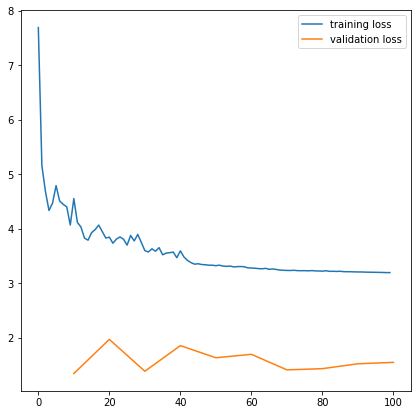

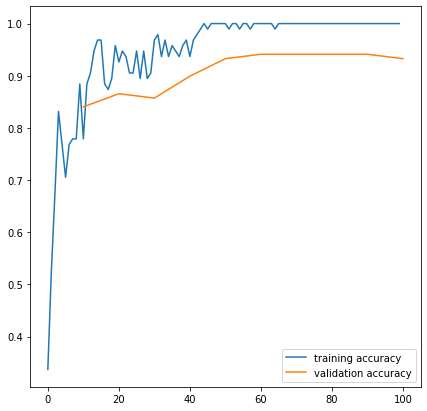

In [ ]:
## training with backpropagating through all the weights (which is wrong)
num_epochs = 100
train(model, train_dataloader, num_epochs)

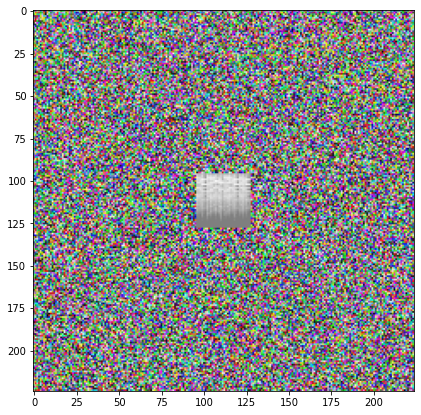

In [ ]:
prog = nn.Tanh()(model.W.detach()*M)
input = dataset[50][0]
# input_m, input_s = input.mean(), input.std()
# input1 = (input - input_m) / input_s
input1 = (input - input.min())/(input.max() - input.min())
input2 = transforms.Resize((32,32))(input1)
input3 = nn.functional.pad(input2,(96,96,96,96),"constant",0)

# input = input/255
# input2 = nn.functional.pad(input1,(37,37,80,80),"constant",0)
out = input3+prog
plt.figure(figsize=(7,7))
out_np = out.numpy()
out_np = out_np*0.5 + 0.5 
plt.imshow(np.moveaxis(out_np,0,2))
plt.show()

In [ ]:
input, label = list(train_dataloader)[0]
input_m, input_s = input.mean(), input.std()
input = (input - input_m) / input_s
_, predictions = torch.max(model(input),1)

In [ ]:
print(predictions)
print(label)

tensor([1, 5, 4, 1, 2, 6, 1, 2])
tensor([1, 5, 4, 1, 2, 6, 1, 2])


In [ ]:
print(_)

tensor([8.0126, 9.1991, 8.7695, 6.7345, 9.3137, 7.4947, 6.9025, 9.7495],
       grad_fn=<MaxBackward0>)


In [ ]:
list(train_dataloader)[0][0][0].size()

torch.Size([3, 64, 150])

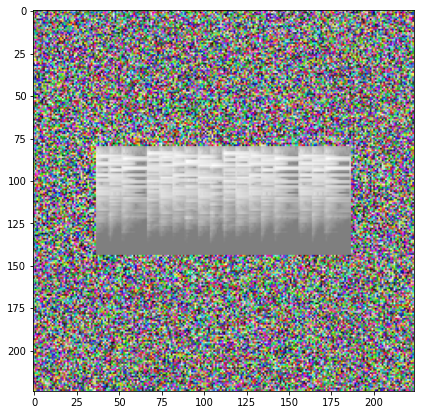

In [ ]:
# model.W.detach().numpy()
prog = nn.Tanh()(model.W.detach()*M)
input = dataset[50][0]
# input_m, input_s = input.mean(), input.std()
# input1 = (input - input_m) / input_s
input1 = (input - input.min())/(input.max() - input.min())

# input = input/255
input2 = nn.functional.pad(input1,(37,37,80,80),"constant",0)
out = input2+prog
plt.figure(figsize=(7,7))
out_np = out.numpy()
out_np = out_np*0.5 + 0.5 
plt.imshow(np.moveaxis(out_np,0,2))
plt.show()

In [ ]:
input.max()

tensor(47.1667)

### some sample spectrograms

In [ ]:
aud, sr = torchaudio.load(data[20]['path'])  # aud=audio tensor, sr=sampling rate    
# preprocessing
aud = ConvertToStereo(aud)       # keeping 2 channels 
aud = ChangeSR(aud,sr,44100)   # choosing the conventional sr 
aud = Resize(aud, 44100, 5)
spec = torchaudio.transforms.Spectrogram()(aud)
spec_amp = torchaudio.transforms.AmplitudeToDB(top_db=80)(spec)
mel_spec = torchaudio.transforms.MelSpectrogram(44100, n_mels=64, n_fft=1024)(aud)
mel_spec_amp = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel_spec)

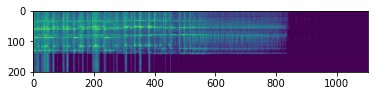

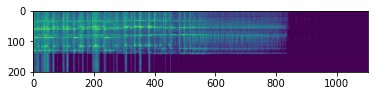

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spec_amp[0,:,:].numpy().squeeze())
plt.figure()
plt.imshow(spec_amp[1,:,:].numpy().squeeze())

# plt.figure()
# plt.imshow(mel_spec[0,:,:].numpy().squeeze())
# plt.figure()
# plt.imshow(mel_spec[1,:,:].numpy().squeeze())

In [ ]:
print(data[0]['label'])
Audio(data[0]['path'])

3


1


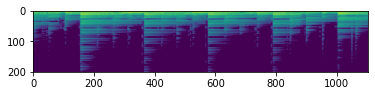

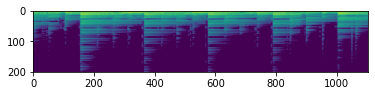

In [ ]:
plt.figure()
plt.imshow(spec_amp[0,:,:].numpy().squeeze())
plt.figure()
plt.imshow(spec_amp[1,:,:].numpy().squeeze())
print(data[80]['label'])

In [ ]:
Audio(data[80]['path'])

5


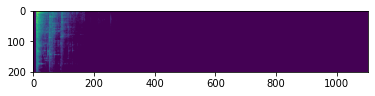

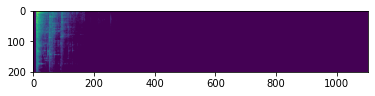

In [ ]:
plt.figure()
plt.imshow(spec_amp[0,:,:].numpy().squeeze())
plt.figure()
plt.imshow(spec_amp[1,:,:].numpy().squeeze())
print(data[100]['label'])

In [ ]:
Audio(data[100]['path'])

4


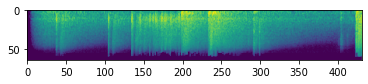

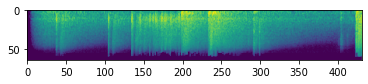

In [ ]:
plt.figure()
plt.imshow(mel_spec_amp[0,:,:].numpy().squeeze())
plt.figure()
plt.imshow(mel_spec_amp[1,:,:].numpy().squeeze())
print(data[118]['label'])

In [ ]:
Audio(data[118]['path'])

In [ ]:
plt.figure()
plt.imshow(mel_spec_amp[0,:,:].numpy().squeeze())
plt.figure()
plt.imshow(mel_spec_amp[1,:,:].numpy().squeeze())
print(data[80]['label'])

1


In [ ]:
Audio(data[80]['path'])

In [ ]:
plt.figure()
plt.imshow(mel_spec_amp[0,:,:].numpy().squeeze())
plt.figure()
plt.imshow(mel_spec_amp[1,:,:].numpy().squeeze())
print(data[20]['label'])

2


In [ ]:
Audio(data[20]['path'])

### References

* L. Smith. _No More Pesky Learning Rate Guessing Games_  https://arxiv.org/pdf/1506.01186v2.pdf

* https://www.vocitec.com/docs-tools/blog/sampling-rates-sample-depths-and-bit-rates-basic-audio-concepts 

* https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P

* https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505